# 1 Corpus beschaffen importieren

In [323]:
TafsirId = 26
Sura = 1
Aya = 6

In [324]:
import create_record as cr
import pandas as pd

corpus = pd.Series({}, dtype="object")

In [325]:
temp = cr.altafsir_extractor(TafsirId, Sura, Aya)
temp.collect_data()
corpus["Text"] = temp.Text

Writing to 26_1_6.txt
Saved file successfully


In [ ]:
temp.write_data()

# 2 Preprocessing
## 2.1 Normalizing data

In [326]:
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.dediac import dediac_ar


def reduce_charset(text):
    import re
    # Remove non-arabic characters
    chars_excluded = '[^\u0621-\u064A ]'
    text = re.sub(chars_excluded, ' ', text)
    return text

def remove_aya(text):
    import re
    # Remove cited aya content
    aya = '\{(.*?)\}'
    text = re.sub(aya, '', text)
    return text

def remove_ref(text):
    import re
    # Remove reference to other ayas
    ref = '\[(.*?)\]'
    text = re.sub(ref, '', text)
    return text

def remove_eulogies(text):
    import re
    with open("./assets/eulogies.txt", encoding="utf-8") as f:
        eulogies = f.read().splitlines()
    for eulogy in eulogies:
        text = re.sub(eulogy, '', text)
    return text


## normalize
def normalizer(string):
    string_normalized = normalize_unicode(string)
    
    # remove diacritica
    string_normalized = dediac_ar(string_normalized)

    string_normalized = remove_ref(string_normalized)
    string_normalized = remove_aya(string_normalized)
    string_normalized = remove_eulogies(string_normalized)
    
    #reduce to arabic charset
    string_normalized = reduce_charset(string_normalized)
    return string_normalized


corpus["TextNormalized"] = normalizer(corpus["Text"])

## 2.2 Tokenization

In [327]:
from camel_tools.tokenizers.word import simple_word_tokenize

corpus["Tokenized"] = simple_word_tokenize(corpus["TextNormalized"])

## 2.3 Disambiguation

In [328]:
from camel_tools.disambig.mle import MLEDisambiguator

# instantiate the Maximum Likelihood Disambiguator
mle = MLEDisambiguator.pretrained()

# The disambiguator expects pre-tokenized text
corpus["disambig"] = mle.disambiguate(corpus["Tokenized"])

In [329]:
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.dediac import dediac_ar

for i, val in enumerate(corpus["disambig"]):
    corpus["disambig"][i].dediaced = normalize_alef_ar(dediac_ar(val.analyses[0].analysis["lex"]))

## 2.4 Deleting Stopwords
### 2.4.1 by Filtering

In [330]:
for i in enumerate(corpus["disambig"]):
    if corpus["disambig"][i[0]].analyses[0].analysis["pos"] in ("conj", "prep", "pron", "abbrev", "pron_dem", "conj_sub"):
        corpus["disambig"].pop(i[0])
        print(i)

(18, DisambiguatedWord(word='في', analyses=[ScoredAnalysis(score=1.0, analysis={'diac': 'فِي', 'lex': 'فِي', 'bw': 'فِي/PREP', 'gloss': 'in', 'pos': 'prep', 'prc3': '0', 'prc2': '0', 'prc1': '0', 'prc0': 'na', 'per': 'na', 'asp': 'na', 'vox': 'na', 'mod': 'na', 'stt': 'na', 'cas': 'na', 'enc0': '0', 'rat': 'na', 'source': 'lex', 'form_gen': 'na', 'form_num': 'na', 'd3seg': 'فِي', 'caphi': 'f_i_y', 'd1tok': 'فِي', 'd2tok': 'فِي', 'pos_logprob': -1.002116, 'd3tok': 'فِي', 'd2seg': 'فِي', 'pos_lex_logprob': -1.411635, 'num': 'na', 'ud': 'ADP', 'gen': 'na', 'catib6': 'PRT', 'root': 'ف.#', 'bwtok': 'فِي', 'pattern': '1ِي', 'lex_logprob': -1.411635, 'atbtok': 'فِي', 'atbseg': 'فِي', 'd1seg': 'فِي', 'stem': 'فِي', 'stemgloss': 'in', 'stemcat': 'FW-Wa'})]))
(19, DisambiguatedWord(word='من', analyses=[ScoredAnalysis(score=1.0, analysis={'diac': 'مِن', 'lex': 'مِن', 'bw': 'مِن/PREP', 'gloss': 'from', 'pos': 'prep', 'prc3': '0', 'prc2': '0', 'prc1': '0', 'prc0': 'na', 'per': 'na', 'asp': 'na', 'v

## 2.5 by using a stopwordlist

In [331]:
## Stopwords provided by nltk
with open("./assets/stopwords_nltk.txt", "r", encoding="utf-8") as sf:
    stopwords_nltk = normalize_alef_ar(dediac_ar(sf.read()))

## Stopwords we chose to include
with open("./assets/stopwords_extra.txt", "r", encoding="utf-8") as sf:
    stopwords_extra = normalize_alef_ar(dediac_ar(sf.read()))

stpws = stopwords_nltk + " " + stopwords_extra
stpws = stpws.split()

In [332]:
def stopwords(token_list, stopwords_list):
    for i, token in enumerate(token_list):
        if token.dediaced in stopwords_list:
            token_list.pop(i)
        else:
            pass
    return None

In [333]:
stopwords(corpus["disambig"], stpws)

In [334]:
corpus["disambig"]

[DisambiguatedWord(word='أخرج', analyses=[ScoredAnalysis(score=1.0, analysis={'diac': 'أَخْرُج', 'lex': 'خَرَج', 'bw': 'أَ/IV1S+خْرُج/IV', 'gloss': 'I+go_out;exit;leave', 'pos': 'verb', 'prc3': '0', 'prc2': '0', 'prc1': '0', 'prc0': '0', 'per': '1', 'asp': 'i', 'vox': 'a', 'mod': 'u', 'stt': 'na', 'cas': 'na', 'enc0': '0', 'rat': 'n', 'source': 'lex', 'form_gen': 'm', 'form_num': 's', 'd3seg': 'أَخْرُج', 'caphi': '2_a_kh_r_u_j', 'd1tok': 'أَخْرُج', 'd2tok': 'أَخْرُج', 'pos_logprob': -1.023208, 'd3tok': 'أَخْرُج', 'd2seg': 'أَخْرُج', 'pos_lex_logprob': -3.793096, 'num': 's', 'ud': 'VERB', 'gen': 'm', 'catib6': 'VRB', 'root': 'خ.ر.ج', 'bwtok': 'أَ+_خْرُج', 'pattern': 'أَ1ْ2ُ3', 'lex_logprob': -3.793096, 'atbtok': 'أَخْرُج', 'atbseg': 'أَخْرُج', 'd1seg': 'أَخْرُج', 'stem': 'خْرُج', 'stemgloss': 'go_out;exit;leave', 'stemcat': 'IV_intr'})]),
 DisambiguatedWord(word='وكيع', analyses=[ScoredAnalysis(score=1.0, analysis={'diac': 'وكيع', 'lex': 'وكيع', 'bw': 'وكيع/NOUN_PROP', 'gloss': 'NO_ANAL

In [335]:
stopwords(corpus["disambig"], stpws)

## 3. Visualize
### 3.1 Visualize Arabic lex frequency

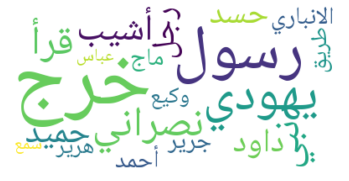

In [336]:
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt          

# for Arabic text
from arabic_reshaper import reshape
from bidi.algorithm import get_display

rtl = lambda w: get_display(reshape(f'{w}'))

COUNTS = Counter([v.analyses[0].analysis["lex"] for v in corpus["disambig"]])
counts = {rtl(k):v for k, v in COUNTS.most_common(20)}

# Output to file
with open(f"./output/freqs_{TafsirId}_{Sura}_{Aya}.csv", 'w', encoding="utf-8") as f:
    for key in counts.keys():
        f.write("%s, %s\n" % (key, counts[key]))


# output to graphics and file
font_file = './assets/NotoNaskhArabic-Regular.ttf'
wordcloud = WordCloud(font_path=font_file, background_color="white").generate_from_frequencies(counts)
wordcloud.to_file(f"./output/{TafsirId}_{Sura}_{Aya}_wc_lex.png")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3.2 Visualize stemgloss frequency

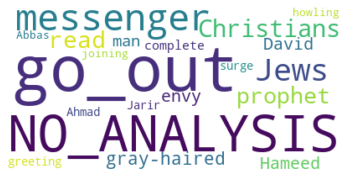

In [339]:
from collections import Counter

from wordcloud import WordCloud          # pip install wordcloud
import matplotlib.pyplot as plt          

param = "stemgloss"

counter_input = [v.analyses[0].analysis[f"{param}"].split(";")[0] for v in corpus["disambig"]]

COUNTS = Counter(counter_input)
counts = {k:v for k, v in COUNTS.most_common(20)}

# Output to file
with open(f"./output/{TafsirId}_{Sura}_{Aya}_{param}_freqs.csv", 'w', encoding="utf-8") as f:
    for key in counts.keys():
        f.write("%s, %s\n" % (key, counts[key]))


# output to graphics and file
wordcloud = WordCloud(background_color="white").generate_from_frequencies(counts)
wordcloud.to_file(f"./output/{TafsirId}_{Sura}_{Aya}_{param}_wc.png")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [338]:
corpus["disambig"]

[DisambiguatedWord(word='أخرج', analyses=[ScoredAnalysis(score=1.0, analysis={'diac': 'أَخْرُج', 'lex': 'خَرَج', 'bw': 'أَ/IV1S+خْرُج/IV', 'gloss': 'I+go_out;exit;leave', 'pos': 'verb', 'prc3': '0', 'prc2': '0', 'prc1': '0', 'prc0': '0', 'per': '1', 'asp': 'i', 'vox': 'a', 'mod': 'u', 'stt': 'na', 'cas': 'na', 'enc0': '0', 'rat': 'n', 'source': 'lex', 'form_gen': 'm', 'form_num': 's', 'd3seg': 'أَخْرُج', 'caphi': '2_a_kh_r_u_j', 'd1tok': 'أَخْرُج', 'd2tok': 'أَخْرُج', 'pos_logprob': -1.023208, 'd3tok': 'أَخْرُج', 'd2seg': 'أَخْرُج', 'pos_lex_logprob': -3.793096, 'num': 's', 'ud': 'VERB', 'gen': 'm', 'catib6': 'VRB', 'root': 'خ.ر.ج', 'bwtok': 'أَ+_خْرُج', 'pattern': 'أَ1ْ2ُ3', 'lex_logprob': -3.793096, 'atbtok': 'أَخْرُج', 'atbseg': 'أَخْرُج', 'd1seg': 'أَخْرُج', 'stem': 'خْرُج', 'stemgloss': 'go_out;exit;leave', 'stemcat': 'IV_intr'})]),
 DisambiguatedWord(word='وكيع', analyses=[ScoredAnalysis(score=1.0, analysis={'diac': 'وكيع', 'lex': 'وكيع', 'bw': 'وكيع/NOUN_PROP', 'gloss': 'NO_ANAL